In [21]:
import time
from time import strftime
import sys

import pandas as pd
import numpy as np

import sklearn
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

%matplotlib inline

random_state = 42
np.random.seed(random_state)

#TODO: naive value and momentum with 1-month returns
# Sharpe
# industry get_dummies(data, drop_first=True)

In [2]:
data = pd.read_pickle("data_forecast.pickle")
data.head()


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET3,LR,XGB,RF,LASSO,RIDGE,EL,MLP
0,1963-01-31,1010,25,1.443624,0.126256,0.077724,0.047872,0.040461,0.064441,0.045532,0.045078,0.047970,0.025177
1,1963-01-31,1040,6,0.448922,-0.477048,0.041148,0.014868,0.027143,0.009025,0.023724,0.017523,0.020167,0.003644
2,1963-01-31,1043,41,0.255952,-0.390406,-0.056931,0.013170,0.037293,-0.076260,0.020386,0.016390,0.016104,0.033915
3,1963-01-31,1045,40,1.383475,-0.130926,0.082269,0.037609,0.052762,0.104746,0.041339,0.036478,0.038684,0.030210
4,1963-01-31,1075,31,0.476919,-0.187948,-0.002032,0.012236,0.000674,0.008528,0.018823,0.016950,0.014485,-0.010149


In [3]:
# get unique dates
# function to take a dataframe, date, column
#   compute quantile for that date, update quantile column, return dataframe
# loop through dates, call function, accumulate dfs in list, concat

# for each quantile
#   use .loc to select rows in that bucket
#   group by date and average performance by date
#   save performance as a series
# plot 10 series

uniquedates = sorted(data["DATETIME"].unique())
uniquedates[:10]

[numpy.datetime64('1963-01-31T00:00:00.000000000'),
 numpy.datetime64('1963-02-28T00:00:00.000000000'),
 numpy.datetime64('1963-03-31T00:00:00.000000000'),
 numpy.datetime64('1963-04-30T00:00:00.000000000'),
 numpy.datetime64('1963-05-31T00:00:00.000000000'),
 numpy.datetime64('1963-06-30T00:00:00.000000000'),
 numpy.datetime64('1963-07-31T00:00:00.000000000'),
 numpy.datetime64('1963-08-31T00:00:00.000000000'),
 numpy.datetime64('1963-09-30T00:00:00.000000000'),
 numpy.datetime64('1963-10-31T00:00:00.000000000')]

In [4]:
num_buckets = 5

def bucket_df_by_col(df, col, num_buckets=num_buckets):
    # compute decile buckets for df.col
    # assign new column col_RANK containing decile bucket for each row
    newcol = col + "_RANK"
    # add a random small num to prevent bucket collisions
    df["tempcol"]=df[col] + np.random.uniform(0,0.0000001,len(df))
    # bucket tempcol into num_buckets quantiles
    vals = pd.qcut(df["tempcol"], num_buckets, labels=False)
    df[newcol] = vals
    #df = df.assign(c=col.values)
    return df


In [5]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "MOMENTUM") for d in uniquedates]
datanew= pd.concat(dflist)
datanew

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET3,LR,XGB,RF,LASSO,RIDGE,EL,MLP,tempcol,MOMENTUM_RANK
0,1963-01-31,1010,25,1.443624,0.126256,0.077724,0.047872,0.040461,0.064441,0.045532,0.045078,0.047970,0.025177,0.126256,4
1,1963-01-31,1040,6,0.448922,-0.477048,0.041148,0.014868,0.027143,0.009025,0.023724,0.017523,0.020167,0.003644,-0.477048,0
2,1963-01-31,1043,41,0.255952,-0.390406,-0.056931,0.013170,0.037293,-0.076260,0.020386,0.016390,0.016104,0.033915,-0.390406,0
3,1963-01-31,1045,40,1.383475,-0.130926,0.082269,0.037609,0.052762,0.104746,0.041339,0.036478,0.038684,0.030210,-0.130926,2
4,1963-01-31,1075,31,0.476919,-0.187948,-0.002032,0.012236,0.000674,0.008528,0.018823,0.016950,0.014485,-0.010149,-0.187948,1
5,1963-01-31,1078,41,0.423057,0.016883,0.167320,0.020121,0.026860,0.116424,0.025389,0.021781,0.022386,0.021057,0.016883,4
6,1963-01-31,1209,14,0.456838,-0.169348,-0.009172,0.023691,0.022971,-0.035766,0.025224,0.024957,0.023846,0.019940,-0.169348,1
7,1963-01-31,1215,14,0.795584,-0.106268,0.085797,0.032440,0.030852,-0.004197,0.032028,0.031756,0.031891,0.024377,-0.106268,2
8,1963-01-31,1221,14,1.499520,0.388141,0.051627,0.053165,0.069969,-0.018707,0.047756,0.047852,0.050844,0.045286,0.388141,4
9,1963-01-31,1243,19,1.072439,-0.158415,0.175573,0.022956,0.024123,0.154098,0.030181,0.024984,0.025254,0.021539,-0.158415,1


,Label,Annualized return,Annualized volatility
0,Quintile 0,7.979007,0.129890
1,Quintile 1,11.603035,0.098937
2,Quintile 2,12.517823,0.091539
3,Quintile 3,13.400055,0.093942
4,Quintile 4,17.007959,0.123248


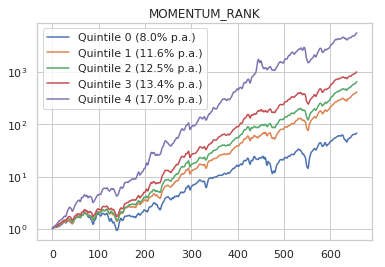

In [6]:
# performance by bucket

col = "MOMENTUM_RANK"
# Assume we put 1/3 port each month in bucket for 3 months
DIVIDE_BY = 3

def perf_by_bucket(df, col, rank, perfcol="RET3"):
    perf = df.loc[df[col]==rank][["DATETIME", col, perfcol]]\
        .groupby("DATETIME")\
        .mean()\
        .reset_index()
    return perf

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, col, i, perfcol="RET3")
    tempdf["RET1P"] = 1 + (tempdf["RET3"] / DIVIDE_BY)
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12)

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)

plt.title(col)
plt.legend();

pd.DataFrame(reportdict)

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


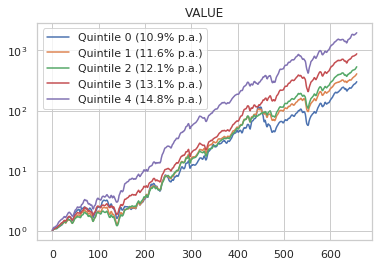

,Label,Annualized return,Annualized volatility
0,Quintile 0,10.940988,0.125537
1,Quintile 1,11.555962,0.107313
2,Quintile 2,12.102128,0.099629
3,Quintile 3,13.121210,0.095582
4,Quintile 4,14.792321,0.099480


In [7]:
def perf_bucket_by_col(data, col, nbuckets=5):

    col_rank = col + "_RANK"

    dflist = [bucket_df_by_col(data[data["DATETIME"]==d], col, nbuckets) for d in uniquedates]
    datanew= pd.concat(dflist)

    reportdict = {'Label': [],
                  'Annualized return' : [],
                  'Annualized volatility' : []}

    for i in range(nbuckets):
        
        tempdf = perf_by_bucket(datanew, col_rank, i, perfcol="RET3")
        # 1-month signal
        tempdf["RET1P"] = 1 + (tempdf["RET3"]/DIVIDE_BY)
        tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()

        lastval = list(tempdf["CUMPERF"])[-1]

        annret = (lastval**(1/55)-1)*100
        vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12)

        plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

        reportdict['Label'].append("Quintile %d " % (i))
        reportdict['Annualized return'].append(annret)
        reportdict['Annualized volatility'].append(vol)
    
    plt.legend();
    plt.title(col)
    plt.show()

    return pd.DataFrame(reportdict)

col = "VALUE"
perf_bucket_by_col(data, col)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


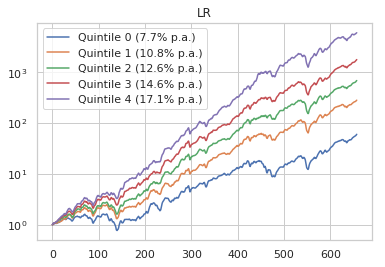

,Label,Annualized return,Annualized volatility
0,Quintile 0,7.748925,0.111845
1,Quintile 1,10.812455,0.100610
2,Quintile 2,12.615143,0.098009
3,Quintile 3,14.570705,0.097378
4,Quintile 4,17.125549,0.106081


In [8]:
# these are in-sample for the training in 3.1 regression
# just tells you if you captured anything at all
# given R-squareds are tiny even in-sample (until RF, XGB)
col = "LR"
perf_bucket_by_col(data, col)

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


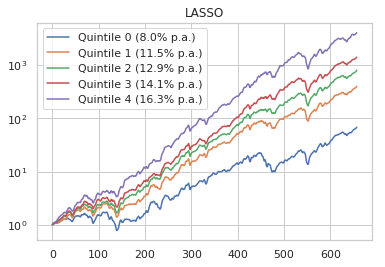

,Label,Annualized return,Annualized volatility
0,Quintile 0,7.984027,0.116667
1,Quintile 1,11.504599,0.102705
2,Quintile 2,12.921515,0.096227
3,Quintile 3,14.082610,0.096429
4,Quintile 4,16.291424,0.104679


In [9]:
col = "LASSO"
perf_bucket_by_col(data, col)
# extreme lasso penalty leads to forecasting nearly same value for everything

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


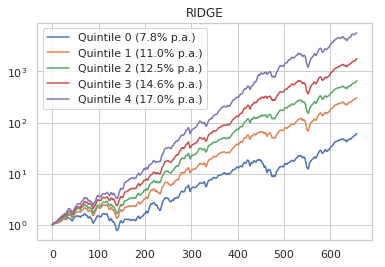

,Label,Annualized return,Annualized volatility
0,Quintile 0,7.779697,0.113609
1,Quintile 1,10.989392,0.100950
2,Quintile 2,12.520540,0.097529
3,Quintile 3,14.559643,0.096901
4,Quintile 4,17.011488,0.105107


In [10]:
col = "RIDGE"
perf_bucket_by_col(data, col)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


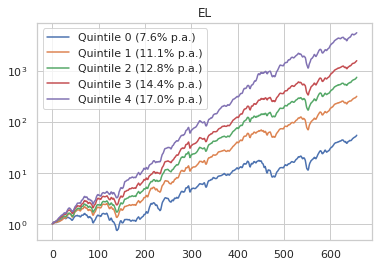

,Label,Annualized return,Annualized volatility
0,Quintile 0,7.579283,0.114188
1,Quintile 1,11.072341,0.100831
2,Quintile 2,12.821293,0.096862
3,Quintile 3,14.366249,0.096952
4,Quintile 4,17.019021,0.105836


In [11]:
col = "EL"
perf_bucket_by_col(data, col)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


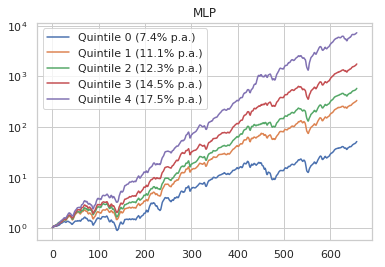

,Label,Annualized return,Annualized volatility
0,Quintile 0,7.414972,0.108054
1,Quintile 1,11.134340,0.097502
2,Quintile 2,12.250122,0.098975
3,Quintile 3,14.536651,0.098642
4,Quintile 4,17.538463,0.112771


In [12]:
col = "MLP"
perf_bucket_by_col(data, col)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


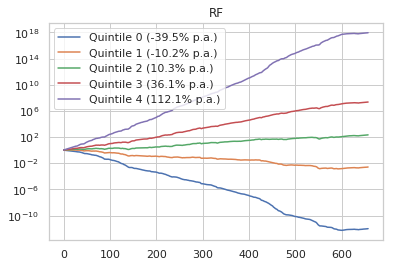

,Label,Annualized return,Annualized volatility
0,Quintile 0,-39.519712,0.132088
1,Quintile 1,-10.227501,0.098972
2,Quintile 2,10.273814,0.093406
3,Quintile 3,36.088843,0.099310
4,Quintile 4,112.098933,0.148616


In [13]:
col = "RF"
perf_bucket_by_col(data, col)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


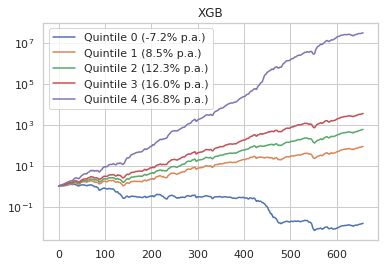

,Label,Annualized return,Annualized volatility
0,Quintile 0,-7.248819,0.120592
1,Quintile 1,8.495137,0.096161
2,Quintile 2,12.337777,0.094567
3,Quintile 3,16.047135,0.095467
4,Quintile 4,36.815923,0.126519


In [14]:
col = "XGB"
perf_bucket_by_col(data, col)


In [15]:
FIRST_TRAIN_MONTHS=120

class BacktestModel():
    
    def __init__(self, 
                 df,
                 create_model=None, 
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):

        # 1st column = dates
        # 2nd column = gvkeys
        self.data = df.copy()
        self.data.sort_values(["DATETIME", "GVKEY"], inplace=True)
        self.data.reset_index(inplace=True)
        self.uniquedates = self.data.groupby("DATETIME")["index"].first().reset_index()
        self.uniquedatelist = list(self.uniquedates["index"])
        self.uniquedatedict = dict(zip(self.uniquedates["DATETIME"], 
                                       self.uniquedates["index"]))
        # last column = target
        self.y = df.iloc[:,-1]
        
        # middle = features
        self.X = df.iloc[:,2:-1]
        self.Xrows, self.Xcols = self.X.shape
        
        # create predictions
        self.P = np.zeros_like(self.y)
        
        self.Xscale = self.X.copy()
        self.yscale = self.y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.yscale = scaler().fit_transform(self.yscale)
        
        self.create_model = create_model
        self.startindex = startindex
        self.fit_missing = fit_missing
        
    def fit_predict(self, train_months, predict_months=1, verbose=False):
        """for backtest, train model  
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain months
        train_stop_index = self.uniquedatelist[train_months]
        if verbose:
            print("Training months 0:%d, indexes 0:%d" % (train_months-1, train_stop_index-1))
        X_fit = self.Xscale[:train_stop_index]  # e.g. 0:120
        y_fit = self.yscale[:train_stop_index]

        # train model
        self.model = self.create_model()
        self.model.fit(X_fit, y_fit)

        # predict npredict months (but don't exceed bounds)
        if train_months+predict_months > len(self.uniquedatelist)-1:
            predict_stop_index = len(self.Xscale)
        else:
            predict_stop_index = self.uniquedatelist[train_months+predict_months]
            
        if verbose:
            print("Predicting months %d:%d, indexes %d:%d" % (train_months, train_months+predict_months-1, 
                                                              train_stop_index, predict_stop_index-1))
        X_predict = self.Xscale[train_stop_index:predict_stop_index] # 121-122
        y_predict = self.model.predict(X_predict)
        #print(y_predict)
        self.P[train_stop_index:predict_stop_index] = y_predict
        return self.P
    
    def gen_predictions_regression(self,
                                   step=1, 
                                   splits=None,
                                   verbose=False):
        """predict all months, pass either step (# months) or total # of splits"""
        print("%s Starting training" % (strftime("%H:%M:%S")))

        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, len(self.uniquedatelist), step))
            
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(len(self.uniquedatelist) - month_indexes[-1])
        
        if verbose:
            print ("Months: " + str(month_indexes))
            print ("Steps: " + str(steps))

        progress_i = 0
            
        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d months (%d:%d), storing predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=verbose)
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")    
        print("%s Starting training" % (strftime("%H:%M:%S")))


In [17]:
backtestmodel = BacktestModel(data[['DATETIME', 'GVKEY', 'MOMENTUM', 'VALUE', 'RET3']],
                              create_model=LinearRegression,
                              startindex=FIRST_TRAIN_MONTHS,
                             )

backtestmodel.gen_predictions_regression(verbose=True)

11:02:15 Starting training
Months: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,

.Training on first 143 months (0:142), storing predictions in rows range(143, 144)
Training months 0:142, indexes 0:85015
Predicting months 143:143, indexes 85016:85909
.Training on first 144 months (0:143), storing predictions in rows range(144, 145)
Training months 0:143, indexes 0:85909
Predicting months 144:144, indexes 85910:86665
.Training on first 145 months (0:144), storing predictions in rows range(145, 146)
Training months 0:144, indexes 0:86665
Predicting months 145:145, indexes 86666:87502
.Training on first 146 months (0:145), storing predictions in rows range(146, 147)
Training months 0:145, indexes 0:87502
Predicting months 146:146, indexes 87503:88323
.Training on first 147 months (0:146), storing predictions in rows range(147, 148)
Training months 0:146, indexes 0:88323
Predicting months 147:147, indexes 88324:89158
.Training on first 148 months (0:147), storing predictions in rows range(148, 149)
Training months 0:147, indexes 0:89158
Predicting months 148:148, indexe

.Training on first 191 months (0:190), storing predictions in rows range(191, 192)
Training months 0:190, indexes 0:124856
Predicting months 191:191, indexes 124857:125666
.Training on first 192 months (0:191), storing predictions in rows range(192, 193)
Training months 0:191, indexes 0:125666
Predicting months 192:192, indexes 125667:126444
.Training on first 193 months (0:192), storing predictions in rows range(193, 194)
Training months 0:192, indexes 0:126444
Predicting months 193:193, indexes 126445:127274
.Training on first 194 months (0:193), storing predictions in rows range(194, 195)
Training months 0:193, indexes 0:127274
Predicting months 194:194, indexes 127275:128037
.Training on first 195 months (0:194), storing predictions in rows range(195, 196)
Training months 0:194, indexes 0:128037
Predicting months 195:195, indexes 128038:128835
.Training on first 196 months (0:195), storing predictions in rows range(196, 197)
Training months 0:195, indexes 0:128835
Predicting months

Predicting months 238:238, indexes 162850:163600
.Training on first 239 months (0:238), storing predictions in rows range(239, 240)
Training months 0:238, indexes 0:163600
Predicting months 239:239, indexes 163601:164393
.Training on first 240 months (0:239), storing predictions in rows range(240, 241)
Training months 0:239, indexes 0:164393
Predicting months 240:240, indexes 164394:165166
.Training on first 241 months (0:240), storing predictions in rows range(241, 242)
Training months 0:240, indexes 0:165166
Predicting months 241:241, indexes 165167:165941
.Training on first 242 months (0:241), storing predictions in rows range(242, 243)
Training months 0:241, indexes 0:165941
Predicting months 242:242, indexes 165942:166724
.Training on first 243 months (0:242), storing predictions in rows range(243, 244)
Training months 0:242, indexes 0:166724
Predicting months 243:243, indexes 166725:167497
.Training on first 244 months (0:243), storing predictions in rows range(244, 245)
Training

Predicting months 286:286, indexes 201651:202484
.Training on first 287 months (0:286), storing predictions in rows range(287, 288)
Training months 0:286, indexes 0:202484
Predicting months 287:287, indexes 202485:203308
.Training on first 288 months (0:287), storing predictions in rows range(288, 289)
Training months 0:287, indexes 0:203308
Predicting months 288:288, indexes 203309:204085
.Training on first 289 months (0:288), storing predictions in rows range(289, 290)
Training months 0:288, indexes 0:204085
Predicting months 289:289, indexes 204086:204873
.Training on first 290 months (0:289), storing predictions in rows range(290, 291)
Training months 0:289, indexes 0:204873
Predicting months 290:290, indexes 204874:205686
.Training on first 291 months (0:290), storing predictions in rows range(291, 292)
Training months 0:290, indexes 0:205686
Predicting months 291:291, indexes 205687:206534
.Training on first 292 months (0:291), storing predictions in rows range(292, 293)
Training

Predicting months 334:334, indexes 240848:241637
.Training on first 335 months (0:334), storing predictions in rows range(335, 336)
Training months 0:334, indexes 0:241637
Predicting months 335:335, indexes 241638:242445
.Training on first 336 months (0:335), storing predictions in rows range(336, 337)
Training months 0:335, indexes 0:242445
Predicting months 336:336, indexes 242446:243257
.Training on first 337 months (0:336), storing predictions in rows range(337, 338)
Training months 0:336, indexes 0:243257
Predicting months 337:337, indexes 243258:244051
.Training on first 338 months (0:337), storing predictions in rows range(338, 339)
Training months 0:337, indexes 0:244051
Predicting months 338:338, indexes 244052:244874
.Training on first 339 months (0:338), storing predictions in rows range(339, 340)
Training months 0:338, indexes 0:244874
Predicting months 339:339, indexes 244875:245712
.Training on first 340 months (0:339), storing predictions in rows range(340, 341)
Training

Predicting months 382:382, indexes 284671:285758
.Training on first 383 months (0:382), storing predictions in rows range(383, 384)
Training months 0:382, indexes 0:285758
Predicting months 383:383, indexes 285759:286809
.Training on first 384 months (0:383), storing predictions in rows range(384, 385)
Training months 0:383, indexes 0:286809
Predicting months 384:384, indexes 286810:287873
.Training on first 385 months (0:384), storing predictions in rows range(385, 386)
Training months 0:384, indexes 0:287873
Predicting months 385:385, indexes 287874:288908
.Training on first 386 months (0:385), storing predictions in rows range(386, 387)
Training months 0:385, indexes 0:288908
Predicting months 386:386, indexes 288909:289965
.Training on first 387 months (0:386), storing predictions in rows range(387, 388)
Training months 0:386, indexes 0:289965
Predicting months 387:387, indexes 289966:291052
.Training on first 388 months (0:387), storing predictions in rows range(388, 389)
Training

Predicting months 430:430, indexes 340234:341449
.Training on first 431 months (0:430), storing predictions in rows range(431, 432)
Training months 0:430, indexes 0:341449
Predicting months 431:431, indexes 341450:342694
.Training on first 432 months (0:431), storing predictions in rows range(432, 433)
Training months 0:431, indexes 0:342694
Predicting months 432:432, indexes 342695:344011
.Training on first 433 months (0:432), storing predictions in rows range(433, 434)
Training months 0:432, indexes 0:344011
Predicting months 433:433, indexes 344012:345378
.Training on first 434 months (0:433), storing predictions in rows range(434, 435)
Training months 0:433, indexes 0:345378
Predicting months 434:434, indexes 345379:346639
.Training on first 435 months (0:434), storing predictions in rows range(435, 436)
Training months 0:434, indexes 0:346639
Predicting months 435:435, indexes 346640:347855
.Training on first 436 months (0:435), storing predictions in rows range(436, 437)
Training

Predicting months 478:478, indexes 396455:397436
.Training on first 479 months (0:478), storing predictions in rows range(479, 480)
Training months 0:478, indexes 0:397436
Predicting months 479:479, indexes 397437:398488
.Training on first 480 months (0:479), storing predictions in rows range(480, 481)
Training months 0:479, indexes 0:398488
Predicting months 480:480, indexes 398489:399523
.Training on first 481 months (0:480), storing predictions in rows range(481, 482)
Training months 0:480, indexes 0:399523
Predicting months 481:481, indexes 399524:400562
.Training on first 482 months (0:481), storing predictions in rows range(482, 483)
Training months 0:481, indexes 0:400562
Predicting months 482:482, indexes 400563:401578
.Training on first 483 months (0:482), storing predictions in rows range(483, 484)
Training months 0:482, indexes 0:401578
Predicting months 483:483, indexes 401579:402542
.Training on first 484 months (0:483), storing predictions in rows range(484, 485)
Training

Predicting months 526:526, indexes 444365:445297
.Training on first 527 months (0:526), storing predictions in rows range(527, 528)
Training months 0:526, indexes 0:445297
Predicting months 527:527, indexes 445298:446259
.Training on first 528 months (0:527), storing predictions in rows range(528, 529)
Training months 0:527, indexes 0:446259
Predicting months 528:528, indexes 446260:447197
.Training on first 529 months (0:528), storing predictions in rows range(529, 530)
Training months 0:528, indexes 0:447197
Predicting months 529:529, indexes 447198:448151
.Training on first 530 months (0:529), storing predictions in rows range(530, 531)
Training months 0:529, indexes 0:448151
Predicting months 530:530, indexes 448152:449087
.Training on first 531 months (0:530), storing predictions in rows range(531, 532)
Training months 0:530, indexes 0:449087
Predicting months 531:531, indexes 449088:450009
.Training on first 532 months (0:531), storing predictions in rows range(532, 533)
Training

Predicting months 574:574, indexes 490168:491117
.Training on first 575 months (0:574), storing predictions in rows range(575, 576)
Training months 0:574, indexes 0:491117
Predicting months 575:575, indexes 491118:492031
.Training on first 576 months (0:575), storing predictions in rows range(576, 577)
Training months 0:575, indexes 0:492031
Predicting months 576:576, indexes 492032:492979
.Training on first 577 months (0:576), storing predictions in rows range(577, 578)
Training months 0:576, indexes 0:492979
Predicting months 577:577, indexes 492980:493918
.Training on first 578 months (0:577), storing predictions in rows range(578, 579)
Training months 0:577, indexes 0:493918
Predicting months 578:578, indexes 493919:494870
.Training on first 579 months (0:578), storing predictions in rows range(579, 580)
Training months 0:578, indexes 0:494870
Predicting months 579:579, indexes 494871:495814
.Training on first 580 months (0:579), storing predictions in rows range(580, 581)
Training

Predicting months 622:622, indexes 537159:538193
.Training on first 623 months (0:622), storing predictions in rows range(623, 624)
Training months 0:622, indexes 0:538193
Predicting months 623:623, indexes 538194:539217
.Training on first 624 months (0:623), storing predictions in rows range(624, 625)
Training months 0:623, indexes 0:539217
Predicting months 624:624, indexes 539218:540281
.Training on first 625 months (0:624), storing predictions in rows range(625, 626)
Training months 0:624, indexes 0:540281
Predicting months 625:625, indexes 540282:541285
.Training on first 626 months (0:625), storing predictions in rows range(626, 627)
Training months 0:625, indexes 0:541285
Predicting months 626:626, indexes 541286:542316
.Training on first 627 months (0:626), storing predictions in rows range(627, 628)
Training months 0:626, indexes 0:542316
Predicting months 627:627, indexes 542317:543366
.Training on first 628 months (0:627), storing predictions in rows range(628, 629)
Training

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


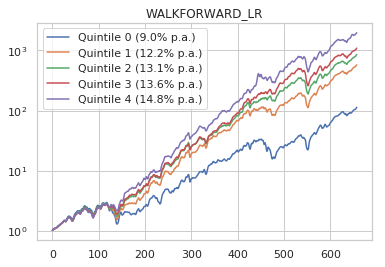

,Label,Annualized return,Annualized volatility
0,Quintile 0,8.984919,0.118079
1,Quintile 1,12.249212,0.103546
2,Quintile 2,13.059473,0.099612
3,Quintile 3,13.566737,0.097186
4,Quintile 4,14.789247,0.102970


In [18]:
col = "WALKFORWARD_LR"
data[col] = backtestmodel.P
perf_bucket_by_col(data, col)



In [22]:
def my_create_model():
    return xgboost.XGBRegressor(n_estimators=400,
                                max_depth=8,
                                n_jobs=-1)

backtestmodel = BacktestModel(data[['DATETIME', 'GVKEY', 'MOMENTUM', 'VALUE', 'RET3']],
                              create_model=my_create_model,
                              startindex=FIRST_TRAIN_MONTHS)

backtestmodel.gen_predictions_regression(verbose=False)

11:04:03 Starting training
................................................................................
11:16:14 Still training step 80 of 538
................................................................................
11:36:35 Still training step 160 of 538
................................................................................
12:05:08 Still training step 240 of 538
................................................................................
12:44:35 Still training step 320 of 538
................................................................................
13:37:25 Still training step 400 of 538
................................................................................
14:42:47 Still training step 480 of 538
..........................................................
15:37:40 Starting training


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


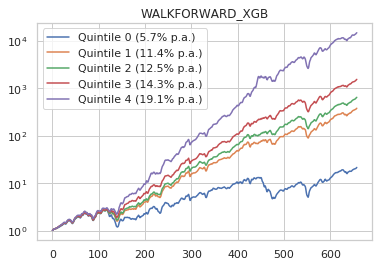

,Label,Annualized return,Annualized volatility
0,Quintile 0,5.744452,0.116983
1,Quintile 1,11.404714,0.097751
2,Quintile 2,12.483165,0.093954
3,Quintile 3,14.276732,0.094686
4,Quintile 4,19.068436,0.114959


In [23]:
col = "WALKFORWARD_XGB"
data[col] = backtestmodel.P
perf_bucket_by_col(data, col)